## Canonical Correlation Analysis

We want to solve the following Canonical Correlation Analysis (CCA) problem:

$P: \text{max}_{X,W}\; \mathbb{E}[\text{trace}(X^T\mathbf{y}(t)\mathbf{v}^T(t)W)]$
$\text{s.t. } \mathbb{E}[X^T\mathbf{y}(t)\mathbf{y}^T(t)X]=I,\; \mathbb{E}[W^T\mathbf{v}(t)\mathbf{v}^T(t)W]=I,$

in a distributed setting using the distributed adaptive signal fusion (DASF) framework.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import networkx as nx
sys.path.append('../dasf_toolbox/')
import cca_functions as cca
from dasf_toolbox import dasf_multivar

rng = np.random.default_rng()

The network on which the CCA problem will be solved is created randomly,
and has 10 nodes and 5 channels/sensors per node. We also see that we have 2 variables.

In [2]:
# Number of nodes.
nbnodes = 10
# Number of channels per node.
nbsensors_vec = 5 * np.ones(nbnodes)
nbsensors_vec = nbsensors_vec.astype(int)
# Number of channels in total.
nbsensors = np.sum(nbsensors_vec)
# Number of variables.
nbvariables = 2
# Create adjacency matrix (hollow matrix) of a random graph.
graph_adj = rng.integers(0, 1, size=(nbnodes, nbnodes), endpoint=True)
graph_adj = np.triu(graph_adj, 1) + np.tril(graph_adj.T, -1)

The adjacency matrix of the network is:

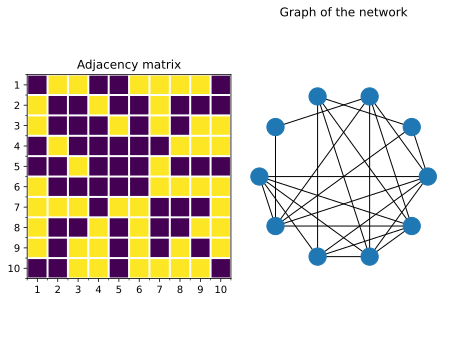

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

fig, ax = plt.subplots(1, 2)
ax[0].imshow(graph_adj)
ax[0].set_xticks(np.arange(0, nbnodes, 1))
ax[0].set_yticks(np.arange(0, nbnodes, 1))
ax[0].set_xticklabels(np.arange(1, nbnodes + 1, 1))
ax[0].set_yticklabels(np.arange(1, nbnodes + 1, 1))
ax[0].set_xticks(np.arange(-.5, nbnodes, 1), minor=True)
ax[0].set_yticks(np.arange(-.5, nbnodes, 1), minor=True)
ax[0].grid(which='minor', color='w', linestyle='-', linewidth=2)
ax[0].set_title('Adjacency matrix')

graph = nx.from_numpy_array(graph_adj)
nx.draw_circular(graph)
ax[1].set_title('Graph of the network')
ax[1].axis('equal')

plt.tight_layout()
plt.show()


We now create the multi-channel signals $\mathbf{y}$ and $\mathbf{v}$
measured at the nodes, using the following mixture model:
$\mathbf{v}(t)=A\cdot\mathbf{d}(t)+\mathbf{n}(t)$,
$\mathbf{y}(t)=\mathbf{v}(t-3).$

Each node measures blocks of 10000 samples to estimate the correlation matrices.

In [4]:
# Number of samples of the signals.
nbsamples = 10000

Y, V = cca.create_data(nbsensors, nbsamples)

The matrices `Y` and `V` contain in their columns time samples of $\mathbf{y}$ and $\mathbf{v}$ respectively:
$Y = [\mathbf{y}(1);\dots;\mathbf{y}(10000)]$ and $V = [\mathbf{v}(1);\dots;\mathbf{v}(10000)]$.

When solving the CCA problem in the DASF setting, we need to use a centralized solver to
solve the local problems created at each different node, where each node solves a parameterized
version of the original problem. The solver we use is `cca_solver` which solves:

$\text{max}_{X_1,X_2}\; \mathbb{E}[\text{trace}(X_1^T\mathbf{y}_1(t)\mathbf{y}_2^T(t)X_2)]$
$\text{s.t. }  \mathbb{E}[X_1^T\mathbf{y}_1(t)\mathbf{y}_1^T(t)X_1]=I,\; \mathbb{E}[X_2^T\mathbf{y}_2(t)\mathbf{y}_2^T(t)X_2]=I.$

Comparing it with problem $P$, we see that we have $\mathbf{y}_1=\mathbf{y}$ and
$\mathbf{y}_2=\mathbf{v}$.

The data of the problem are stored in the dictionary `data` (see documentation for
more information).

In [5]:
Y_list = [Y]
V_list = [V]
Gamma_list = []
B_list = []
Glob_Const_list = []

data_X = {'Y_list': Y_list, 'B_list': B_list,
        'Gamma_list': Gamma_list, 'Glob_Const_list': Glob_Const_list}
data_W = {'Y_list': V_list, 'B_list': B_list,
        'Gamma_list': Gamma_list, 'Glob_Const_list': Glob_Const_list}

data = [data_X, data_W]


In the distributed setting, each node $q$ will solve a parameterized version of the problem $P$
given by:

$\text{max}_{\widetilde{X}_q,\widetilde{W}_q}\; \mathbb{E}[\text{trace}(\widetilde{X}_q^TC_q^T\mathbf{y}(t)\mathbf{v}^T(t)C_q\widetilde{W}_q)]$
$\text{s.t. }  \mathbb{E}[\widetilde{X}_q^TC_q^T\mathbf{y}(t)\mathbf{y}^T(t)C_q\widetilde{X}_q]=I,\; \mathbb{E}[\widetilde{W}_q^TC_q^T\mathbf{v}(t)\mathbf{v}^T(t)C_q\widetilde{W}_q]=I.$

Therefore, in `cca_solver`, we take $\mathbf{y}_1=C_q^T\mathbf{y}$ and
$\mathbf{y}_2=C_q^T\mathbf{v}$.

The parameters of the problem are stored in the dictionary `prob_params` (see documentation for
more information), where we choose the number of filters $Q$ (i.e., the number of columns of
$X$) to be equal to 2:

In [6]:
# Number of filters of X.
Q = 2

prob_params = {'nbnodes': nbnodes, 'nbsensors_vec': nbsensors_vec,
                   'nbsensors': nbsensors, 'Q': Q, 'nbsamples': nbsamples, 'nbvariables': nbvariables}

The optimal filter $X^*$ is estimated using the centralized solver `cca_solver` taking
as input the data and problem parameters previously defined:

In [7]:
X_star = cca.cca_solver(prob_params, data, X0=None, solver_params=None)
f_star = cca.cca_eval(X_star, data) # f(X_star)

For the distributed context, we take the previously created network, and choose a randomly
generated sequence as the updating path, i.e., the order in which the nodes take turns
in solving their local problem.

We also fix the number of iterations of the DASF algorithm to be equal to 1000.

In [8]:
prob_params['graph_adj'] = graph_adj

update_path = rng.permutation(range(nbnodes))
prob_params['update_path'] = update_path

nbiter = 1000
conv = {'nbiter': nbiter}

We also provide $X^*$ to compare the estimation we get from the DASF algorithm to the optimal
value.

In [9]:
prob_params['X_star'] = X_star
prob_params['compare_opt'] = True

Finally, the GEVD problem is solved in a distributed setting using the DASF framework:

In [10]:
X_est, norm_diff, norm_err, f_seq = dasf_multivar(prob_params, data, cca.cca_solver,
                                             conv, solver_params=None, prob_select_sol=cca.cca_select_sol, prob_eval=cca.cca_eval)

Let us look at the plot of the normalized error $\frac{||X^i-X^*||_F^2}{||X^*||_F^2}$:

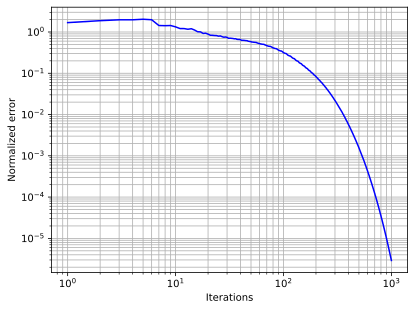

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.loglog(range(1, nbiter + 1), norm_err, color='b')
ax.set_xlabel('Iterations')
ax.set_ylabel('Normalized error')
ax.grid(True, which='both')
plt.show()